Imports

In [1]:
from qiskit import QuantumCircuit, Aer, assemble
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy import pi
from random import random
from random import seed

In [2]:
svsim = Aer.get_backend('aer_simulator')

Algoritmo base


In [3]:
def rotation_circuit(n, thetas):
  """
  Creates a circuit with rotated qubits (Cx)

  Args:
    n (int): Numbers of qubits
    thetas (list(ints)): Array of rotation angles

  Returns:
    QuantumCircuit
  """

  qc = QuantumCircuit(n)
  
  for i in range(n - 1):
    qc.rx(thetas[i], i)

  qc.barrier()

  return qc


In [4]:
def duration_gate():
  """
  Randomly rotates a qubit
  Args:
  """
  qc = QuantumCircuit(1)
  theta=random()*2*pi
  qc.rx(theta, 0)
  qc.barrier()

  return qc

Algoritmos parametrizados

In [5]:
def entanglement_qutrit(i, j, k):
  """
  Args:
    i (int): Classical bit, 0 or 1
    j (int): Classical bit, 0 or 1
    k (int): Classical bit, 0 or 1
  
  Returns:
    QuantumCircuit: Circuit after applying H gates and CNOTs
  """
  qc = QuantumCircuit(3)
  
  if i == 1:
    qc.h(0)
  if j == 1:
    qc.h(1)
  if k == 1:
    qc.h(2)
  
  qc.cx(0, 1)
  qc.cx(0, 2)
  
  return qc

In [6]:
def entanglement_circuit(n, phase):
  qc = QuantumCircuit(n)
  time_circuit = entanglement_qutrit(1, 0, 0)
  note_circuit = entanglement_qutrit(1, 0, 0)
  
  circuit = qc.compose(time_circuit, [0,1,2]).compose(note_circuit, [3,4,5])
  
  circuit.barrier()

  return circuit

Idea: El entralazamiento "elimina" muchas superposiciones, solo existen algunas viables. Por lo tanto, es una manera de manipular directamente que notas/tiempos se van a tocar. Control directo :)

Pruebas

In [7]:
# Test joining
qc = QuantumCircuit(7)
rotations = rotation_circuit(7, [0, 0, 0, pi/5, pi/4, pi/3])
entangled = entanglement_circuit(7, 0)
duration = duration_gate()

qc = qc.compose(rotations).compose(duration, 6).compose(entangled)
qc.draw()

┌───────┐  ░      ┌───┐                ░ 
q_0: ─┤ Rx(0) ├──░──────┤ H ├───────■────■───░─
      ├───────┤  ░      └───┘     ┌─┴─┐  │   ░ 
q_1: ─┤ Rx(0) ├──░────────────────┤ X ├──┼───░─
      ├───────┤  ░                └───┘┌─┴─┐ ░ 
q_2: ─┤ Rx(0) ├──░─────────────────────┤ X ├─░─
     ┌┴───────┴┐ ░      ┌───┐          └───┘ ░ 
q_3: ┤ Rx(π/5) ├─░──────┤ H ├───────■────■───░─
     ├─────────┤ ░      └───┘     ┌─┴─┐  │   ░ 
q_4: ┤ Rx(π/4) ├─░────────────────┤ X ├──┼───░─
     ├─────────┤ ░                └───┘┌─┴─┐ ░ 
q_5: ┤ Rx(π/3) ├─░─────────────────────┤ X ├─░─
     └─────────┘ ░ ┌─────────────┐  ░  └───┘ ░ 
q_6: ────────────░─┤ Rx(0.27563) ├──░────────░─
                 ░ └─────────────┘  ░        ░

In [8]:
# Let's get the result:
qc.save_statevector()
qobj = assemble(qc)
result = svsim.run(qobj).result()

# Print the statevector neatly:
final_state = result.get_statevector()


In [9]:
hist = result.get_counts()

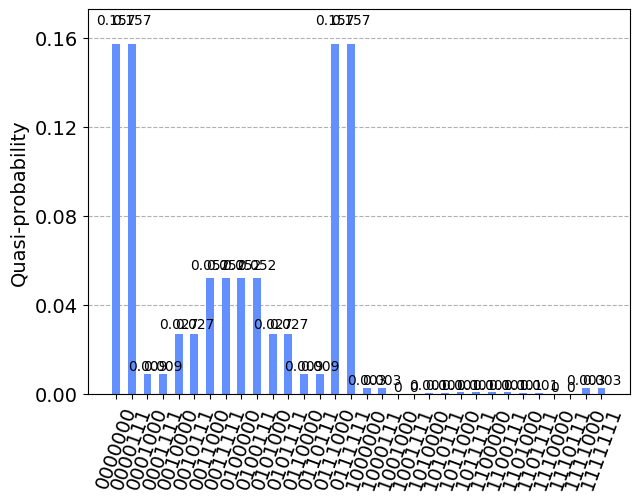

In [10]:
plot_histogram(result.get_counts())

# Playing music

In [11]:
from pygame import mixer
import pygame
import time
import numpy as np
from os import listdir
pygame.init();

pygame 2.1.3 (SDL 2.0.22, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [12]:
bd = mixer.Sound("./audio/drums/bd click.wav")
sn = mixer.Sound("./audio/drums/sd tone.wav")
hh = mixer.Sound("./audio/drums/hihat a.wav")
notes = [mixer.Sound("./audio/synth1/"+ii) for ii in listdir("./audio/synth1")]

In [13]:
# Extract keys and vals
keys = np.array(list(hist.keys()))
amplitudes = np.array(list(hist.values()))

In [14]:
# Filter data
thresh = 1 / (2 * len(keys))
mask = (amplitudes > thresh)

# Filter with boolean mask
keys = keys[mask]
amplitudes = amplitudes[mask]

In [15]:
keys

array(['0000000', '0000111', '0010000', '0010111', '0011000', '0011111',
       '0100000', '0100111', '0101000', '0101111', '0111000', '0111111'],
      dtype='<U7')

In [16]:
# select sequences to play
counts = len(keys)

# For storing
melody_index = []
time_index = []

for i in range(counts):
    # Correct order
    qubits = keys[i][::-1]

    # First three are note in binary
    note = int(qubits[0:3], 2)

    # 4, 5, 6 are beat in binary
    beat = int(qubits[3:6], 2)

    # Append
    melody_index.append(note)
    time_index.append(beat)

# To np array
melody_index = np.array(melody_index)
time_index = np.array(time_index)

In [17]:
time_index

array([0, 0, 2, 2, 6, 6, 1, 1, 5, 5, 7, 7])

In [18]:
melody_index

array([0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7])

In [19]:
bpm = 200
bps = bpm / 60
nbeats = 8
total_time = nbeats / bps
grid_time = 1 / bps # time per every beat
nloops = 2

# melody_index = np.random.choice(range(len(notes)),nbeats) # note[index] to play

timer = pygame.time.Clock()
# melody_bool = [1,1,1,1,1,1,1,1] # which notes to play
melody_bool = np.random.choice((0,1),nbeats)

# melody loops
for _ in range(nloops): 
    # plays melody
    for i in range(nbeats): 
        # i is current beat
        mask = time_index == i

        # filter for notes on current beat
        current_notes = melody_index[mask]

        # Loop notes and play them
        for n in current_notes:
            notes[n].play()
        # mask = time_index[time_index == ii]
        # if ii == time_index[ii]: print(ii)#notes[melody_index[ii]].play()
        # 
        time.sleep(grid_time / 2) # sleep time

In [20]:
mask = time_index[time_index == 1]
melody_index = np.array(melody_index)

In [21]:
melody_index

array([0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7])